# When running the fit in Step 2, we assume that there will be three rotationally-split components. This is not always the case and can lead to scenarios where an incorrect rotational splitting is determined.

## These are failure modes that are easily remedied by visual inspection (and have been already done in the context of the paper). In the interest of reproducibility, this notebook will describe how incorrect fits as a result of the default triplet rotational splitting assumptions are identified.

In [107]:
import os, sys, matplotlib, corner
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import scipy.stats as stats
import time as timer

sys.path.append('../')

from scipy.stats import qmc
from sklearn.neighbors import KDTree
from TuRBO.turbo import Turbo1, TurboM
from TuRBO.turbo.utils import from_unit_cube, latin_hypercube, to_unit_cube
from scipy.spatial.distance import cdist
from sloscillations import mixed_modes_utils, frequencies
from tqdm import tqdm_notebook as tqdm
from scipy.optimize import linear_sum_assignment
from scipy.spatial import KDTree
from copy import deepcopy
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
from matplotlib import rc


## Loading in helper functions needed to process the spectrum.


In [108]:
#' It is assumed that DeltaNu is in μHz
def DeltaPi1_from_DeltaNu_RGB(DeltaNu):
    # Compute Period spacing (in s) from deltanu
    return 60 + 1.7*DeltaNu

def Lor_model(pds, peak):
    return peak.height / (1 + ((pds.frequency.values - peak.frequency)/peak.linewidth)**2)

def sinc2_model(pds, peak):
    deltanu = np.mean(np.diff(pds.frequency.values))
    return peak.height * np.sinc((pds.frequency.values - peak.frequency)/deltanu)**2

def fit_model(pds, peaks):

    model = np.ones_like(pds.frequency.values)

    for i in range(len(peaks)):
        if np.isfinite(peaks.linewidth.iloc[i]):
            model += Lor_model(pds, peaks.iloc[i,])
        else:
            model += sinc2_model(pds, peaks.iloc[i, ])
    return model

def prepare_l1_peaks(peaks: pd.DataFrame, summary: pd.DataFrame,
                     AIC_cut: [float] = 0.0, height_cut: [float] = 0.0) -> pd.DataFrame:
    """
    Extract the mixed modes from the peaks dataframe.
    
    Parameters
    ----------
    peaks: pd.DataFrame
        Dataframe containing the detected peaks and parameters.
        
    summary: pd.DataFrame
        Dataframe containing the global stellar information.
    
    AIC_cut: Optional[float] = 0.0
        Cut to make in the Akaike Information Criterion if desired.
        
    height_cut: Optional[float] = 0.0
        Cut to make in the mode height if desired.
        
    Outputs
    -------
    pd.DataFrame
        Dataframe containing the mixed mode peaks and associated mode parameters.
    """
    peaks['x'] = ((peaks['frequency'] % summary['DeltaNu'].values - summary['eps_p'].values) / summary['DeltaNu'].values) % 1
    # Don't want to include any modes near l=0 or 2s, this is why this and the step in the next cell is performed.
    x_range = [(np.minimum(np.min(peaks.loc[peaks['l'] == 0, 'x']), np.min(peaks.loc[peaks['l'] == 2, 'x'])) - 0.05) % 1,
               (np.maximum(np.max(peaks.loc[peaks['l'] == 0, 'x']), np.max(peaks.loc[peaks['l'] == 2, 'x'])) + 0.05) % 1]
    
    l1_peaks = peaks.loc[(peaks.l == 1) | ~np.isfinite(peaks.l) | (peaks.l == 3)]
    l1_peaks['x'] = ((l1_peaks['frequency'] % summary['DeltaNu'].values - summary['eps_p'].values) / summary['DeltaNu'].values) % 1
    if x_range[0] < x_range[1]:
        l1_peaks = l1_peaks.loc[(l1_peaks['x'] < x_range[1]) | (l1_peaks['x'] > x_range[0]), ] # changed to OR for HeB
    else:
        print(x_range)
        l1_peaks = l1_peaks.loc[(l1_peaks['x'] > x_range[1]) & (l1_peaks['x'] < x_range[0]), ]


    l1_peaks = l1_peaks.loc[(l1_peaks['height'] > height_cut), ]
    l1_peaks = l1_peaks.loc[(l1_peaks['AIC'] > AIC_cut), ]

    return l1_peaks

## Loading in our results datafile

In [109]:
results = pd.read_csv(os.path.split(os.getcwd())[0] + '/results/tables/Table1_seis.csv')
results

,KIC,numax,numax_std,Deltanu,Deltanu_err,DPi1,dpi_e,dpi_E,q,q_e,q_E,eps_g,eps_g_e,eps_g_E,drot,drot_e,drot_E,feh,mass,mass_std
0,1027337,74.587,1.492,6.953,0.002,70.243,0.065,0.045,0.077,0.016,0.022,-0.015,0.144,0.100,0.000,0.000,0.000,0.208,1.304,0.080
1,1430118,159.315,3.186,13.327,0.002,83.029,0.027,0.439,0.155,0.014,0.022,0.330,0.288,0.034,0.279,0.045,0.188,-0.158,1.051,0.057
2,1433803,150.604,3.012,12.166,0.002,80.221,0.010,0.268,0.138,0.019,0.016,0.039,0.109,0.022,0.399,0.174,0.442,0.263,1.231,0.070
3,1569842,135.204,2.704,11.818,0.003,80.708,0.144,0.079,0.155,0.018,0.017,0.195,0.134,0.105,0.366,0.027,0.030,-0.280,0.984,0.057
4,1719422,135.204,2.704,11.281,0.002,76.931,0.009,0.027,0.139,0.007,0.004,0.414,0.033,0.008,0.268,0.009,0.007,-0.282,1.282,0.074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1063,12554556,108.354,2.167,9.006,0.002,77.806,0.011,0.014,0.115,0.005,0.003,0.178,0.017,0.012,0.487,0.015,0.002,0.059,1.559,0.092
1064,12557207,84.797,1.696,8.084,0.003,74.263,0.064,0.043,0.111,0.035,0.038,0.100,0.040,0.167,0.000,0.000,0.000,-0.126,1.037,0.062
1065,12601771,178.448,3.569,14.461,0.003,85.046,0.040,0.095,0.160,0.002,0.016,0.237,0.067,0.033,0.352,0.044,0.003,-0.188,1.028,0.058
1066,12834442,158.921,3.178,13.323,0.004,83.629,0.036,0.049,0.148,0.020,0.017,0.243,0.013,0.002,0.569,0.041,0.010,NaN,NaN,NaN


## We will additionally show results from an early, unvetted run to showcase common scenarios that happen when we assume a triplet scenario.

In [110]:
donefile = pd.read_csv(os.path.split(os.getcwd())[0] + '/results/auxiliary/rotation_results_AIC10.txt', header=None)
donefile.columns = ['KIC', 'DPi1', 'q', 'eps_g', 'drot', 'loss', 'pct_diff1', 'pct_diff2', 'pct_diff3']
eyeball = pd.read_csv(os.path.split(os.getcwd())[0] + '/results/auxiliary/rotation_AIC10_eyeball_flag.csv')
donefile = donefile.merge(eyeball, on='KIC')
donefile = donefile[donefile.rotation_flag != 2]
donefile

,KIC,DPi1,q,eps_g,drot,loss,pct_diff1,pct_diff2,pct_diff3,rotation_flag
0,1723752,83.938,0.160,0.206,0.671,0.248,1011.93,59.69,243.21,0
1,1430118,83.029,0.155,0.330,0.279,0.274,10.79,577.43,847.47,0
2,2018537,80.471,0.218,0.500,0.181,0.263,301.51,43.92,240.70,3
3,1726291,82.546,0.176,0.290,0.541,0.188,360.46,150.53,83.77,0
4,1569842,80.708,0.155,0.195,0.366,0.098,475.08,184.15,142.42,0
...,...,...,...,...,...,...,...,...,...,...
1109,12155459,88.542,0.168,0.153,0.600,0.144,722.95,573.38,2.94,3
1110,11960195,78.433,0.134,0.244,0.282,0.096,218.08,119.17,440.86,0
1111,11391750,72.324,0.125,0.004,0.064,0.419,284.33,10.21,7.15,1
1112,12203243,84.882,0.173,0.094,0.364,0.232,176.40,354.43,17.39,3


## First we define a function to handle the data input, returning a Frequencies object to compute the mixed mode information.

In [111]:
def generate_freqs_object(kic, use_old=False):
    
    data_folder = os.path.split(os.getcwd())[0] + '/peakbag/main_sample/00%d/' %kic
    
    if not os.path.exists(data_folder):
        data_folder = os.path.split(os.getcwd())[0] + '/peakbag/main_sample/0%d/' %kic
    
    summary = pd.read_csv(data_folder + 'summary.csv')
    pds = pd.read_csv(data_folder + 'pds_bgr.csv')
    peaks = pd.read_csv(data_folder + 'peaksMLE.csv')

    prepped_l1_peaks = prepare_l1_peaks(peaks, summary=summary, AIC_cut=10)


    ## Only keep pds around oscillations
    pds = pds.loc[abs(pds['frequency'].values - summary['numax'].values) < 3 * summary['sigmaEnv'].values, ]
    peaks = peaks.loc[abs(peaks.frequency.values - summary.numax.values) < 3*summary.sigmaEnv.values, ]

    l023_peaks = peaks.loc[(peaks.l == 0) | (peaks.l == 2) | (peaks.l == 3), ]
    l0_peaks = peaks.loc[(peaks.l==0), ]
    l1_peaks = peaks.loc[(peaks.l == 1) | (np.isfinite(peaks.l) == False)]
    l2_peaks = peaks.loc[(peaks.l==2), ]

    ## Divide the data through by the model of the l=0,2 modes
    pds_l023_removed = pds.assign(power = pds.power / fit_model(pds, l023_peaks))

    freqs_class = frequencies.Frequencies(frequency=pds_l023_removed.frequency.values,
                                    numax=summary.numax.values, 
                                    delta_nu=summary.DeltaNu.values if np.isfinite(summary.DeltaNu.values) else None, 
                                    epsilon_p=summary.eps_p.values if np.isfinite(summary.eps_p.values) else None,
                                    alpha=summary.alpha.values if np.isfinite(summary.alpha.values) else None)


    inp_freqs = prepped_l1_peaks['frequency'].values
    prepped_l1_peaks['weights'] = (prepped_l1_peaks['amplitude']/np.sum(prepped_l1_peaks['amplitude']))*1000.
    
    if not use_old:
        idx = np.where(results.KIC.values == kic)
        cand_dpi, cand_q, cand_eps_g, cand_rot = results.DPi1.values[idx], results.q.values[idx], results.eps_g.values[idx], results.drot.values[idx]
    else:
        idx = np.where(donefile.KIC.values == kic)
        cand_dpi, cand_q, cand_eps_g, cand_rot = donefile.DPi1.values[idx], donefile.q.values[idx], donefile.eps_g.values[idx], donefile.drot.values[idx]
            
    
    params = {'calc_l0': True, 
                'calc_l2': True, 
                'calc_l3': False, 
                'calc_nom_l1': True, 
                'calc_mixed': True, 
                'calc_rot': False, 
                'DPi1': cand_dpi,
                'coupling': cand_q,
                'eps_g': cand_eps_g,
                'l': 1, 
                }

    freqs_class(params)
    freqs_class.generate_tau_values()
    
    return freqs_class, inp_freqs, cand_rot

## Also a function to compute the quantities to plot

In [125]:
def generate_plot_data(freqs_obj, inp_freqs, splitting):
    
    # Calculating tau for the real modes
    
    colors = ['#1FE08D', '#8D1FE0', '#E08D1F']
    
    real_tau = mixed_modes_utils.peaks_stretched_period(inp_freqs, 
                                                             freqs_obj.frequency, 
                                                             freqs_obj.tau)
    real_tau = real_tau - freqs_obj.DPi1*(freqs_obj.shift)


    # Calculating tau and frequencies for the synthetic modes

    freqs_p1 = freqs_obj.l1_mixed_freqs + freqs_obj.l1_zeta * splitting
    freqs_n1 = freqs_obj.l1_mixed_freqs - freqs_obj.l1_zeta * splitting

    tau_p1 = mixed_modes_utils.peaks_stretched_period(freqs_p1, freqs_obj.frequency, freqs_obj.tau)
    tau_n1 = mixed_modes_utils.peaks_stretched_period(freqs_n1, freqs_obj.frequency, freqs_obj.tau)

    model_freqs = np.c_[freqs_obj.l1_mixed_freqs, freqs_p1, freqs_n1]
    model_tau = np.c_[freqs_obj.l1_mixed_tau, tau_p1, tau_n1]

    # Putting the synthetic freq-tau combination together into a vector X

    X = np.c_[np.r_[model_tau[:,0],
                    model_tau[:,1] - freqs_obj.shift * freqs_obj.DPi1, 
                    model_tau[:,2] - freqs_obj.shift * freqs_obj.DPi1], 
              np.r_[model_freqs[:,0],
                    model_freqs[:,1], 
                    model_freqs[:,2]]]

    color_vec = np.r_[ [colors[0]]*len(model_tau[:,0]), 
                     [colors[1]]*len(model_tau[:,1]),
                      [colors[2]]*len(model_tau[:,2]), 
                     ]

    ## Wrapping the tau values for both model and observed for plotting the stretched echelle
    plot_tau = np.mod(real_tau, freqs_obj.DPi1)
    plot_tau[plot_tau > freqs_obj.DPi1/2] -= freqs_obj.DPi1
    plot_model_tau = np.mod(X[:,0], freqs_obj.DPi1)
    plot_model_tau[plot_model_tau > freqs_obj.DPi1/2] -=  freqs_obj.DPi1
    
    
    return X, plot_tau, plot_model_tau, model_tau, real_tau, model_freqs, color_vec

#  This function is the primary aspect of how we identify incorrect fits: we remove rotationally split components of the synthetic modes and then calculate the relative loss from those removal.

## We first remove the m=0 component, then the m=+1 component, then the m=-1 component.


In [113]:
def calculate_losses(X, model_tau, model_freqs, real_tau, freqs_obj):
    
    X_no0 = np.c_[np.r_[model_tau[:,1] - freqs_obj.shift * freqs_obj.DPi1,  # scenario where m=0 is removed
                    model_tau[:,2] - freqs_obj.shift * freqs_obj.DPi1], 
              np.r_[model_freqs[:,1], 
                    model_freqs[:,2]]]
    X_nop1 = np.c_[np.r_[model_tau[:,0], # scenario where m=+1 is removed
                    model_tau[:,2] - freqs_obj.shift * freqs_obj.DPi1], 
              np.r_[model_freqs[:,0],
                    model_freqs[:,2]]]
    X_non1 = np.c_[np.r_[model_tau[:,0], # scenario where m=-1 is removed
                    model_tau[:,1] - freqs_obj.shift * freqs_obj.DPi1], 
              np.r_[model_freqs[:,0],
                    model_freqs[:,1]]]

    X_list = [X, X_no0, X_nop1, X_non1]
    condition = ['m=0 Removal', 'm=+1 Removal', 'm=-1 Removal']
    
    pct_diff_vec = []
    
    ## We calculate the relative impact of removing the m= +/-1 components relative to the cost of the original solution 
    
    for i, inp in enumerate(X_list):
        c1 = np.vstack((inp[:,0]/freqs_obj.DPi1, (inp[:,1]-freqs_obj.numax)/freqs_obj.delta_nu)).T
        c2 = np.vstack((real_tau/freqs_obj.DPi1, (inp_freqs-freqs_obj.numax)/freqs_obj.delta_nu)).T

        tree = KDTree(c1)
        nearest_dists, nearest_idx = tree.query(c2, k=1)
        kost = np.median(nearest_dists)
        
        if i == 0:
            prime_cost = kost # prime_cost is the cost of the original solution
        else:
            pct_diff = np.abs((kost-prime_cost)*100./prime_cost)
            pct_diff_vec.append(np.round(pct_diff, 2))


    
    return kost, np.array(pct_diff_vec)

# Example 1: KIC 4912918. This star is viewed nearly edge-on, so we really see only two rotationally-split components. 

### The correct solution is on the left, while the incorrect fit is on the right. The incorrect fit assigns model frequencies corresponding to m= 0, -1 to the peakbagged modes, which is unphysical. However, the BayesOpt costs for these two solutions are identical!

### By comparing the relative cost of removing different rotational components, we can easily spot bad fits. Note these are different between the two fits.

In [158]:
plt.style.reload_library() 
# plt.style.use(['science','ieee'])# Fancy Fancy
plt.style.use(['default'])# Default

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = ['serif']
mpl.rcParams['font.serif'] = ['Cantarell']

In [159]:
kicx = 4912918

freqs_class, inp_freqs, correct_rotation = generate_freqs_object(kic=kicx, use_old=False)
freqs_class_wrong, _ , wrong_rotation = generate_freqs_object(kic=kicx, use_old=True)

<ipython-input-108-ec4d195fd1d7>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l1_peaks['x'] = ((l1_peaks['frequency'] % summary['DeltaNu'].values - summary['eps_p'].values) / summary['DeltaNu'].values) % 1


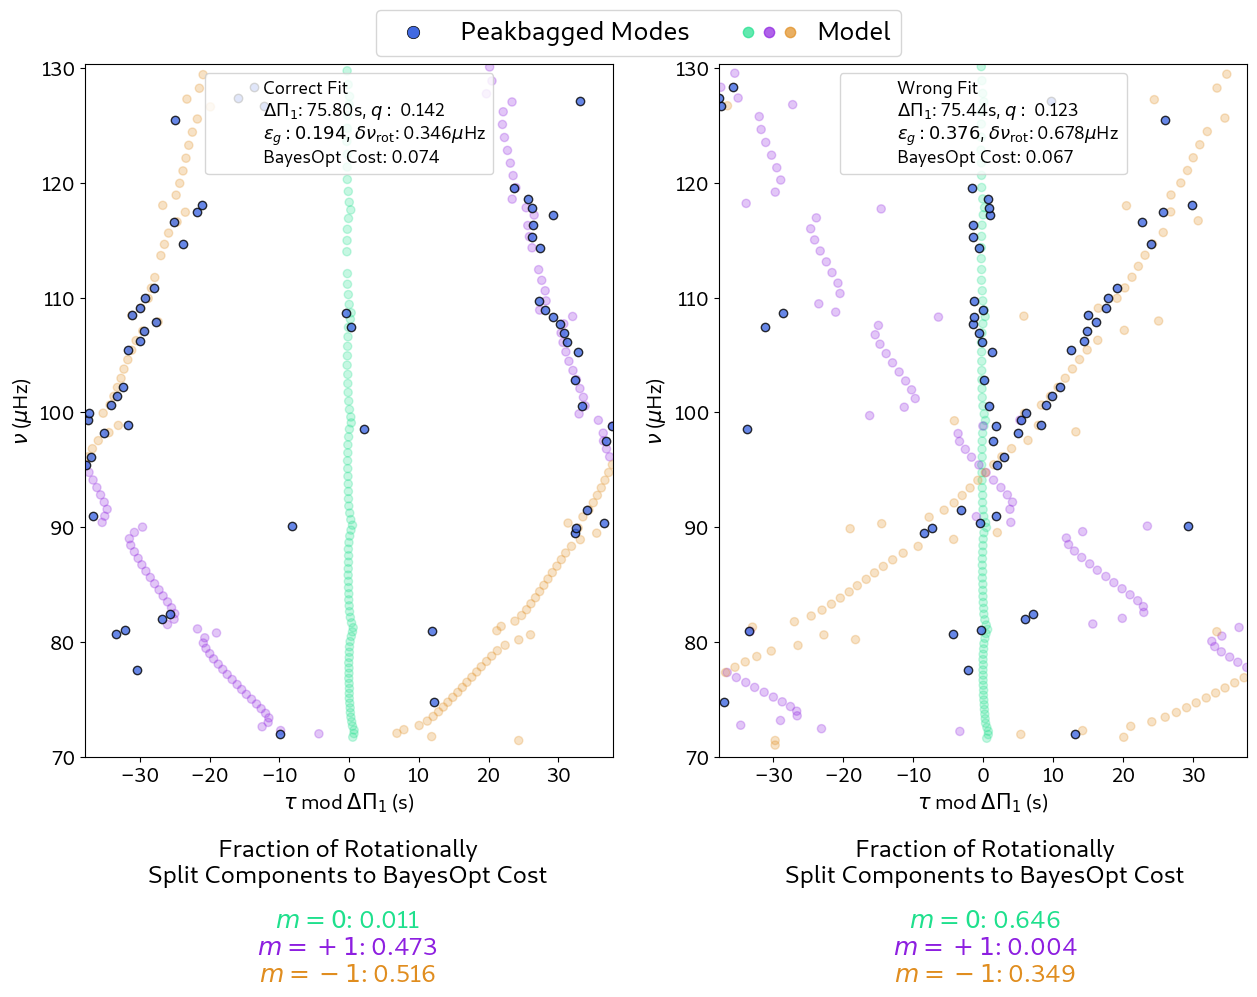

In [161]:
fig = plt.figure(figsize=(15,9))
ax, ax2 = fig.add_subplot(121), fig.add_subplot(122)
axlist = [ax, ax2]
frq_cls = [freqs_class, freqs_class_wrong]
split = [correct_rotation, wrong_rotation]
pos = [0.3, 0.725]
wr_label = ['Correct Fit', 'Wrong Fit']

fs = 15

for i, ax in enumerate(axlist):

    X, plot_tau, plot_model_tau, model_tau, real_tau, model_freqs, color_vec = generate_plot_data(frq_cls[i], inp_freqs, splitting = split[i])
    ori_cost, rel_cost = calculate_losses(X, model_tau, model_freqs, real_tau, frq_cls[i])
    
    
    ax.scatter(plot_model_tau, X[:,1], s=35, c=color_vec, alpha=0.25)
    ax.scatter([], [], c='white',   
                label='%s\n$\\Delta\\Pi_1$: %.2fs, $q:$ %.3f\n$\\epsilon_g: %.3f$, $\\delta\\nu_\\mathrm{rot}$: %.3f$\\mu$Hz\nBayesOpt Cost: %.3f'
               %(wr_label[i], frq_cls[i].DPi1, frq_cls[i].coupling, frq_cls[i].eps_g, split[i], ori_cost))
    
    ax.scatter(plot_tau, inp_freqs, 
                c='royalblue', edgecolor='k', alpha=0.8)
    ax.set_ylim(np.min(inp_freqs)-2, np.max(inp_freqs)+2)
    ax.set_ylabel('$\\nu$ ($\\mu$Hz)', fontsize=fs)
    ax.set_xlabel('$\\tau$ mod $\\Delta\\Pi_1$ (s)', fontsize=fs)
    ax.set_xlim(-frq_cls[i].DPi1/2, frq_cls[i].DPi1/2)
    ax.legend(prop={'size': fs-2})
    ax.tick_params(axis='both', which='major', labelsize=fs)
    
    fig.text(s='Fraction of Rotationally\nSplit Components to BayesOpt Cost', x=pos[i], y=-0.03, fontsize=fs+3, ha='center')
    fig.text(s='$m=0$: %.3f' %((rel_cost/np.sum(rel_cost))[0]), x=pos[i], y=-0.08, fontsize=fs+3, ha='center', color=np.unique(color_vec)[0])
    fig.text(s='$m=+1$: %.3f' %((rel_cost/np.sum(rel_cost))[1]) , x=pos[i], y=-0.11, fontsize=fs+3, ha='center', color=np.unique(color_vec)[1])
    fig.text(s='$m=-1$: %.3f'%((rel_cost/np.sum(rel_cost))[2]) , x=pos[i], y=-0.14, fontsize=fs+3, ha='center', color=np.unique(color_vec)[2])



# For overhead legend #
obs = plt.scatter([],[], s=80, c='royalblue', edgecolor='k', alpha=1, lw=0.5, label='Observed')
model_0 = plt.scatter([],[], s=55, c=np.unique(color_vec)[0], alpha=0.7,
                    label='Model')
model_1 = plt.scatter([],[], s=55, c=np.unique(color_vec)[1], alpha=0.7,
                    label='Model')
model_2 = plt.scatter([],[], s=55, c=np.unique(color_vec)[2], alpha=0.7,
                    label='Model')
    
lech = fig.legend([(obs), (model_0, model_1, model_2)], 
               ['Peakbagged Modes', 'Model'],
               numpoints=1,
              handler_map={tuple: HandlerTuple(ndivide=None)}, prop={'size': fs+4}, loc='upper left',
                 bbox_to_anchor=(0.31,0.955), ncol=3)
plt.show()

# Example 2: KIC 7777395. Similar to Example 1, this star is viewed nearly edge-on, so we really see only two rotationally-split components. 

### Again, the incorrect fit assigns model frequencies corresponding to m= 0, -1 to the peakbagged modes, which is unphysical. The BayesOpt costs for these two solutions are also identical! Note, however, the difference in relative cost of removing different rotational components. 

### Correctly assigned doublets should have $m=\pm1$ component removals result in roughly equal contribution to the total cost. This is the case in the left plot, but not the right.

In [173]:
kicx = 7777395

freqs_class, inp_freqs, correct_rotation = generate_freqs_object(kic=kicx, use_old=False)
freqs_class_wrong, _ , wrong_rotation = generate_freqs_object(kic=kicx, use_old=True)

<ipython-input-108-ec4d195fd1d7>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l1_peaks['x'] = ((l1_peaks['frequency'] % summary['DeltaNu'].values - summary['eps_p'].values) / summary['DeltaNu'].values) % 1


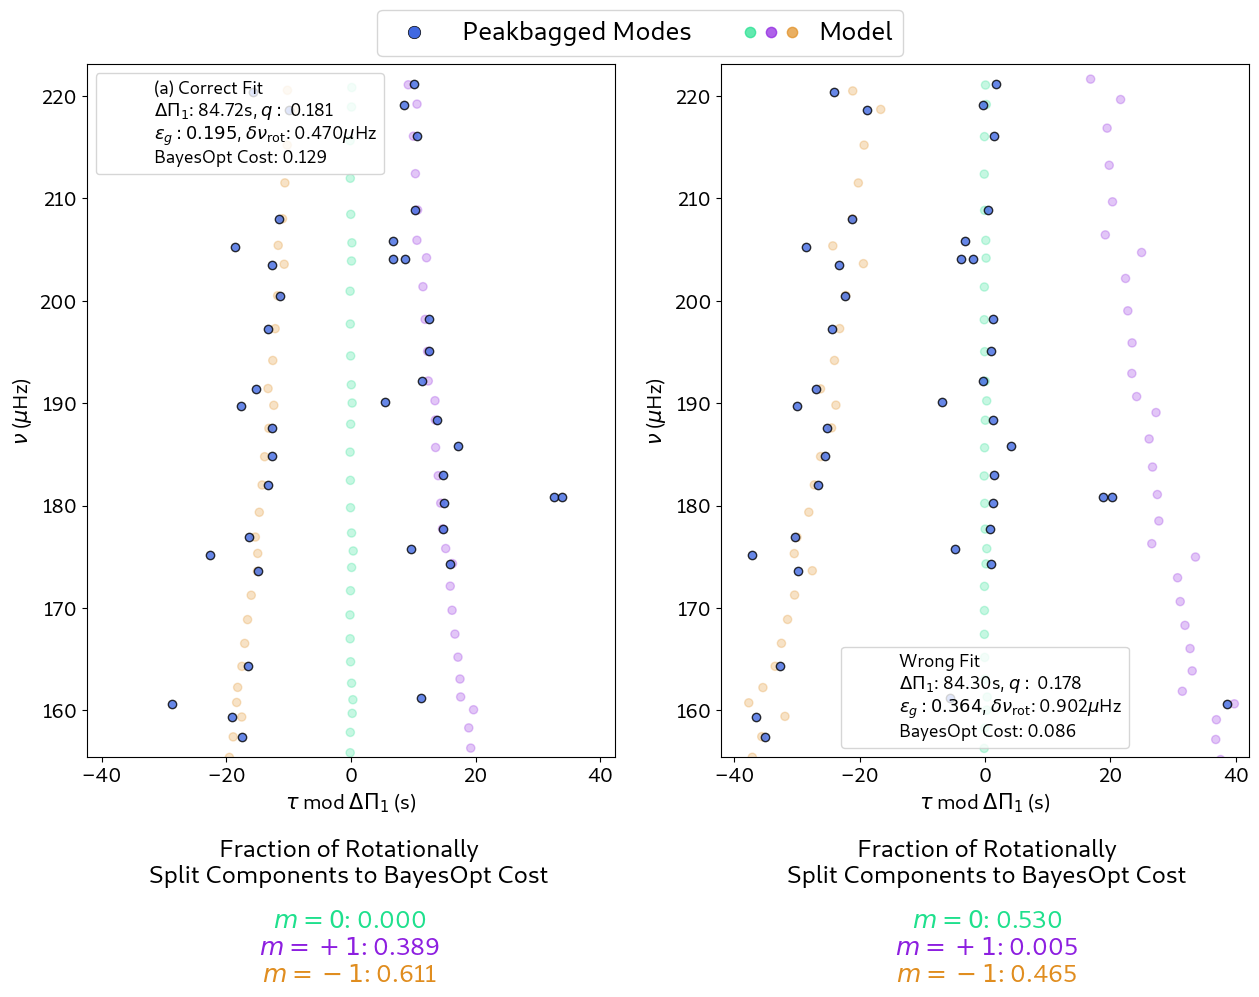

In [174]:
fig = plt.figure(figsize=(15,9))
ax, ax2 = fig.add_subplot(121), fig.add_subplot(122)
axlist = [ax, ax2]
frq_cls = [freqs_class, freqs_class_wrong]
split = [correct_rotation, wrong_rotation]
pos = [0.3, 0.725]
wr_label = ['Correct Fit', 'Wrong Fit']

fs = 15

for i, ax in enumerate(axlist):

    X, plot_tau, plot_model_tau, model_tau, real_tau, model_freqs, color_vec = generate_plot_data(frq_cls[i], inp_freqs, splitting = split[i])
    ori_cost, rel_cost = calculate_losses(X, model_tau, model_freqs, real_tau, frq_cls[i])
    
    
    ax.scatter(plot_model_tau, X[:,1], s=35, c=color_vec, alpha=0.25)
    ax.scatter([], [], c='white',   
                label='%s\n$\\Delta\\Pi_1$: %.2fs, $q:$ %.3f\n$\\epsilon_g: %.3f$, $\\delta\\nu_\\mathrm{rot}$: %.3f$\\mu$Hz\nBayesOpt Cost: %.3f'
               %(wr_label[i], frq_cls[i].DPi1, frq_cls[i].coupling, frq_cls[i].eps_g, split[i], ori_cost))
    
    ax.scatter(plot_tau, inp_freqs, 
                c='royalblue', edgecolor='k', alpha=0.8)
    ax.set_ylim(np.min(inp_freqs)-2, np.max(inp_freqs)+2)
    ax.set_ylabel('$\\nu$ ($\\mu$Hz)', fontsize=fs)
    ax.set_xlabel('$\\tau$ mod $\\Delta\\Pi_1$ (s)', fontsize=fs)
    ax.set_xlim(-frq_cls[i].DPi1/2, frq_cls[i].DPi1/2)
    ax.legend(prop={'size': fs-2})
    ax.tick_params(axis='both', which='major', labelsize=fs)
    
    fig.text(s='Fraction of Rotationally\nSplit Components to BayesOpt Cost', x=pos[i], y=-0.03, fontsize=fs+3, ha='center')
    fig.text(s='$m=0$: %.3f' %((rel_cost/np.sum(rel_cost))[0]), x=pos[i], y=-0.08, fontsize=fs+3, ha='center', color=np.unique(color_vec)[0])
    fig.text(s='$m=+1$: %.3f' %((rel_cost/np.sum(rel_cost))[1]) , x=pos[i], y=-0.11, fontsize=fs+3, ha='center', color=np.unique(color_vec)[1])
    fig.text(s='$m=-1$: %.3f'%((rel_cost/np.sum(rel_cost))[2]) , x=pos[i], y=-0.14, fontsize=fs+3, ha='center', color=np.unique(color_vec)[2])



# For overhead legend #
obs = plt.scatter([],[], s=80, c='royalblue', edgecolor='k', alpha=1, lw=0.5, label='Observed')
model_0 = plt.scatter([],[], s=55, c=np.unique(color_vec)[0], alpha=0.7,
                    label='Model')
model_1 = plt.scatter([],[], s=55, c=np.unique(color_vec)[1], alpha=0.7,
                    label='Model')
model_2 = plt.scatter([],[], s=55, c=np.unique(color_vec)[2], alpha=0.7,
                    label='Model')
    
lech = fig.legend([(obs), (model_0, model_1, model_2)], 
               ['Peakbagged Modes', 'Model'],
               numpoints=1,
              handler_map={tuple: HandlerTuple(ndivide=None)}, prop={'size': fs+4}, loc='upper left',
                 bbox_to_anchor=(0.31,0.955), ncol=3)
plt.show()

# Example 3: KIC 8429977. This time we have a star with only one rotational component being fit to a set of synthetic modes with three rotationally split components.

### The incorrect fit assigns all peakbagged frequencies corresponding to the m= +1 ridge. Note, that the relative cost is purely concentrated now in the m= +1 components.

In [162]:
kicx = 8429977

freqs_class, inp_freqs, correct_rotation = generate_freqs_object(kic=kicx, use_old=False)
freqs_class_wrong, _ , wrong_rotation = generate_freqs_object(kic=kicx, use_old=True)

<ipython-input-108-ec4d195fd1d7>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l1_peaks['x'] = ((l1_peaks['frequency'] % summary['DeltaNu'].values - summary['eps_p'].values) / summary['DeltaNu'].values) % 1


[0.9513746675969027, 0.04448083965835403]
[0.9513746675969027, 0.04448083965835403]


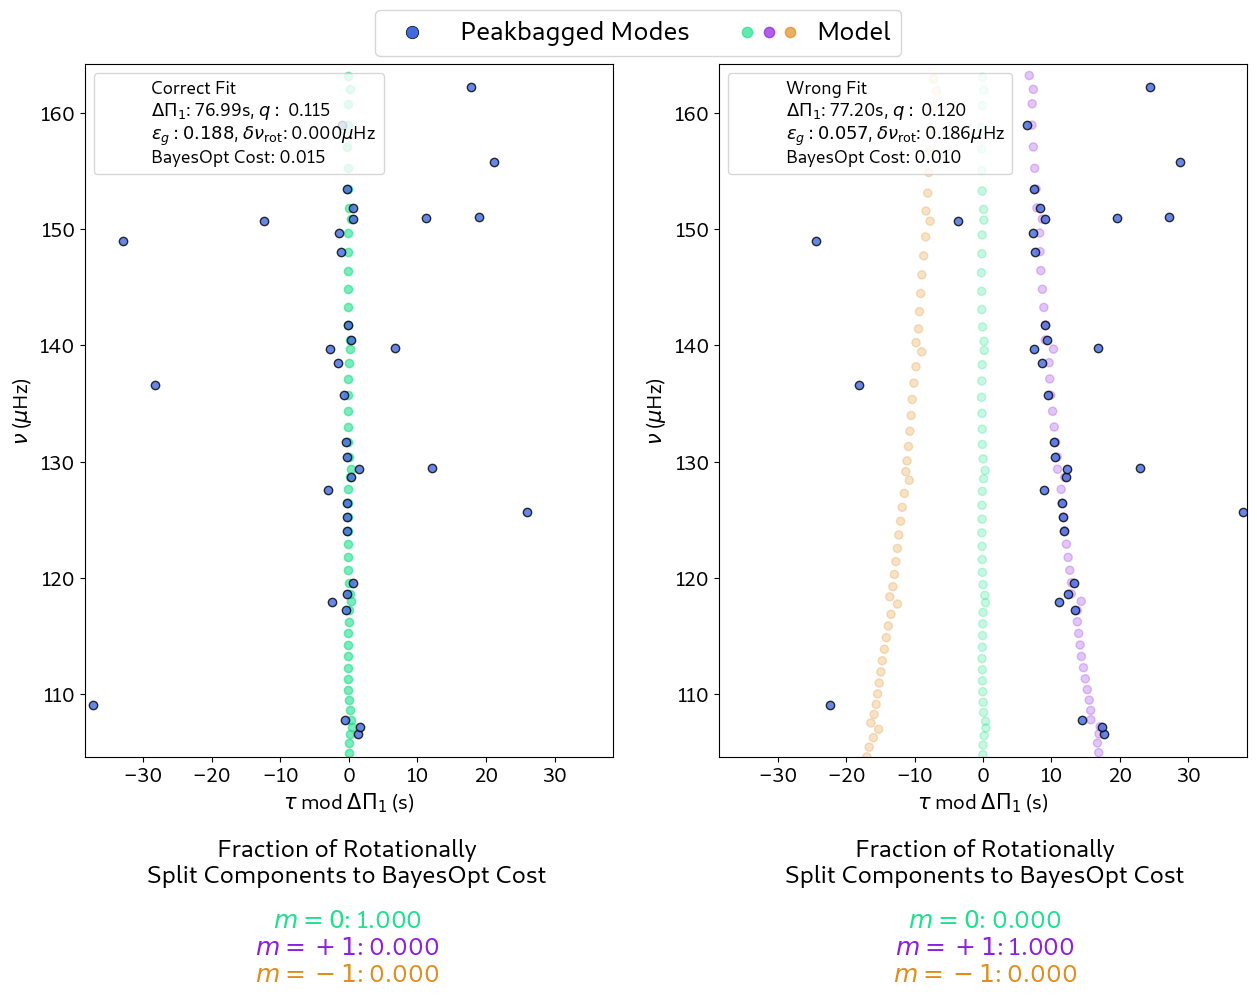

In [163]:
fig = plt.figure(figsize=(15,9))
ax, ax2 = fig.add_subplot(121), fig.add_subplot(122)
axlist = [ax, ax2]
frq_cls = [freqs_class, freqs_class_wrong]
split = [correct_rotation, wrong_rotation]
pos = [0.3, 0.725]
wr_label = ['Correct Fit', 'Wrong Fit']

fs = 15

for i, ax in enumerate(axlist):

    X, plot_tau, plot_model_tau, model_tau, real_tau, model_freqs, color_vec = generate_plot_data(frq_cls[i], inp_freqs, splitting = split[i])
    ori_cost, rel_cost = calculate_losses(X, model_tau, model_freqs, real_tau, frq_cls[i])
    
    if np.sum(rel_cost) == 0:
        rel_cost[0] += 1
        
    if split[i] == 0:
        ax.scatter(plot_model_tau, X[:,1], s=35, c=np.unique(color_vec)[0], alpha=0.25)
    else:
        ax.scatter(plot_model_tau, X[:,1], s=35, c=color_vec, alpha=0.25)

    ax.scatter([], [], c='white',   
                label='%s\n$\\Delta\\Pi_1$: %.2fs, $q:$ %.3f\n$\\epsilon_g: %.3f$, $\\delta\\nu_\\mathrm{rot}$: %.3f$\\mu$Hz\nBayesOpt Cost: %.3f'
               %(wr_label[i], frq_cls[i].DPi1, frq_cls[i].coupling, frq_cls[i].eps_g, split[i], ori_cost))
    
    ax.scatter(plot_tau, inp_freqs, 
                c='royalblue', edgecolor='k', alpha=0.8)
    ax.set_ylim(np.min(inp_freqs)-2, np.max(inp_freqs)+2)
    ax.set_ylabel('$\\nu$ ($\\mu$Hz)', fontsize=fs)
    ax.set_xlabel('$\\tau$ mod $\\Delta\\Pi_1$ (s)', fontsize=fs)
    ax.set_xlim(-frq_cls[i].DPi1/2, frq_cls[i].DPi1/2)
    ax.legend(prop={'size': fs-2})
    ax.tick_params(axis='both', which='major', labelsize=fs)
    
    fig.text(s='Fraction of Rotationally\nSplit Components to BayesOpt Cost', x=pos[i], y=-0.03, fontsize=fs+3, ha='center')
    fig.text(s='$m=0$: %.3f' %((rel_cost/np.sum(rel_cost))[0]), x=pos[i], y=-0.08, fontsize=fs+3, ha='center', color=np.unique(color_vec)[0])
    fig.text(s='$m=+1$: %.3f' %((rel_cost/np.sum(rel_cost))[1]) , x=pos[i], y=-0.11, fontsize=fs+3, ha='center', color=np.unique(color_vec)[1])
    fig.text(s='$m=-1$: %.3f'%((rel_cost/np.sum(rel_cost))[2]) , x=pos[i], y=-0.14, fontsize=fs+3, ha='center', color=np.unique(color_vec)[2])



# For overhead legend #
obs = plt.scatter([],[], s=80, c='royalblue', edgecolor='k', alpha=1, lw=0.5, label='Observed')
model_0 = plt.scatter([],[], s=55, c=np.unique(color_vec)[0], alpha=0.7,
                    label='Model')
model_1 = plt.scatter([],[], s=55, c=np.unique(color_vec)[1], alpha=0.7,
                    label='Model')
model_2 = plt.scatter([],[], s=55, c=np.unique(color_vec)[2], alpha=0.7,
                    label='Model')
    
lech = fig.legend([(obs), (model_0, model_1, model_2)], 
               ['Peakbagged Modes', 'Model'],
               numpoints=1,
              handler_map={tuple: HandlerTuple(ndivide=None)}, prop={'size': fs+4}, loc='upper left',
                 bbox_to_anchor=(0.31,0.955), ncol=3)
plt.show()

# Example 4: KIC 8173581. Another example of a star with only the $m=0$ component.

In [138]:
kicx = 8173581

freqs_class, inp_freqs, correct_rotation = generate_freqs_object(kic=kicx, use_old=False)
freqs_class_wrong, _ , wrong_rotation = generate_freqs_object(kic=kicx, use_old=True)

<ipython-input-108-ec4d195fd1d7>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l1_peaks['x'] = ((l1_peaks['frequency'] % summary['DeltaNu'].values - summary['eps_p'].values) / summary['DeltaNu'].values) % 1


[0.950473062324171, 0.02777455845345478]
[0.950473062324171, 0.02777455845345478]


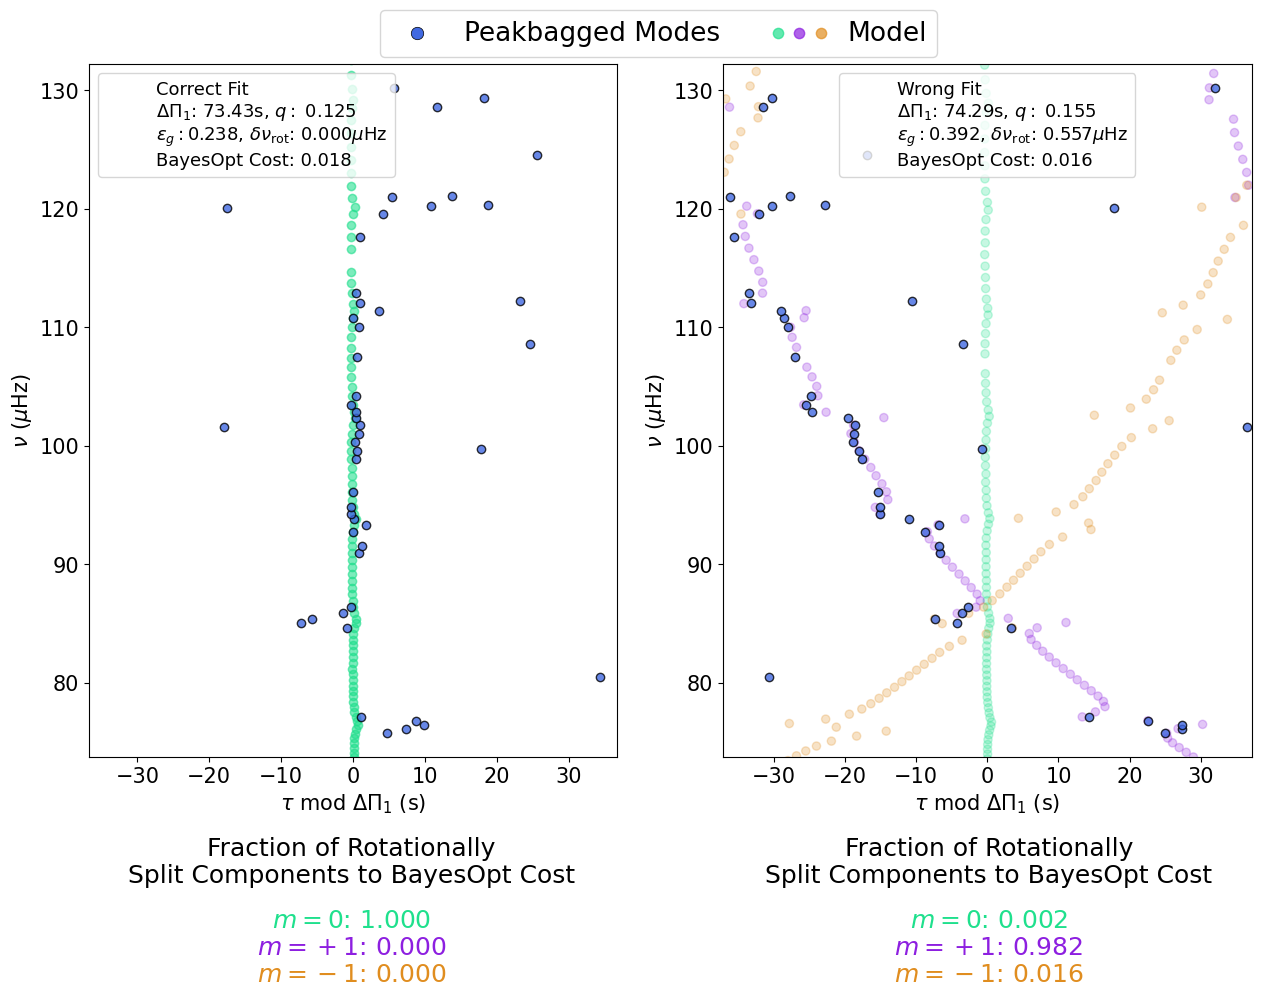

In [139]:
fig = plt.figure(figsize=(15,9))
ax, ax2 = fig.add_subplot(121), fig.add_subplot(122)
axlist = [ax, ax2]
frq_cls = [freqs_class, freqs_class_wrong]
split = [correct_rotation, wrong_rotation]
pos = [0.3, 0.725]
wr_label = ['Correct Fit', 'Wrong Fit']

fs = 15

for i, ax in enumerate(axlist):

    X, plot_tau, plot_model_tau, model_tau, real_tau, model_freqs, color_vec = generate_plot_data(frq_cls[i], inp_freqs, splitting = split[i])
    ori_cost, rel_cost = calculate_losses(X, model_tau, model_freqs, real_tau, frq_cls[i])
    
    if np.sum(rel_cost) == 0:
        rel_cost[0] += 1
    
    if split[i] == 0:
        ax.scatter(plot_model_tau, X[:,1], s=35, c=np.unique(color_vec)[0], alpha=0.25)
    else:
        ax.scatter(plot_model_tau, X[:,1], s=35, c=color_vec, alpha=0.25)
    
    ax.scatter([], [], c='white',   
                label='%s\n$\\Delta\\Pi_1$: %.2fs, $q:$ %.3f\n$\\epsilon_g: %.3f$, $\\delta\\nu_\\mathrm{rot}$: %.3f$\\mu$Hz\nBayesOpt Cost: %.3f'
               %(wr_label[i], frq_cls[i].DPi1, frq_cls[i].coupling, frq_cls[i].eps_g, split[i], ori_cost))
    
    ax.scatter(plot_tau, inp_freqs, 
                c='royalblue', edgecolor='k', alpha=0.8)
    ax.set_ylim(np.min(inp_freqs)-2, np.max(inp_freqs)+2)
    ax.set_ylabel('$\\nu$ ($\\mu$Hz)', fontsize=fs)
    ax.set_xlabel('$\\tau$ mod $\\Delta\\Pi_1$ (s)', fontsize=fs)
    ax.set_xlim(-frq_cls[i].DPi1/2, frq_cls[i].DPi1/2)
    ax.legend(prop={'size': fs-2})
    ax.tick_params(axis='both', which='major', labelsize=fs)
    
    fig.text(s='Fraction of Rotationally\nSplit Components to BayesOpt Cost', x=pos[i], y=-0.03, fontsize=fs+3, ha='center')
    fig.text(s='$m=0$: %.3f' %((rel_cost/np.sum(rel_cost))[0]), x=pos[i], y=-0.08, fontsize=fs+3, ha='center', color=np.unique(color_vec)[0])
    fig.text(s='$m=+1$: %.3f' %((rel_cost/np.sum(rel_cost))[1]) , x=pos[i], y=-0.11, fontsize=fs+3, ha='center', color=np.unique(color_vec)[1])
    fig.text(s='$m=-1$: %.3f'%((rel_cost/np.sum(rel_cost))[2]) , x=pos[i], y=-0.14, fontsize=fs+3, ha='center', color=np.unique(color_vec)[2])



# For overhead legend #
obs = plt.scatter([],[], s=80, c='royalblue', edgecolor='k', alpha=1, lw=0.5, label='Observed')
model_0 = plt.scatter([],[], s=55, c=np.unique(color_vec)[0], alpha=0.7,
                    label='Model')
model_1 = plt.scatter([],[], s=55, c=np.unique(color_vec)[1], alpha=0.7,
                    label='Model')
model_2 = plt.scatter([],[], s=55, c=np.unique(color_vec)[2], alpha=0.7,
                    label='Model')
    
lech = fig.legend([(obs), (model_0, model_1, model_2)], 
               ['Peakbagged Modes', 'Model'],
               numpoints=1,
              handler_map={tuple: HandlerTuple(ndivide=None)}, prop={'size': fs+4}, loc='upper left',
                 bbox_to_anchor=(0.31,0.955), ncol=3)
plt.show()

## By plotting the fractional cost of each rotation component across stars, we can easily identify which ones have incorrect fits and which ones are correct.

### We will now show the 'triangle' plot of fractional costs from an early run with incorrect assignments. Note where our previous examples land on each plot!

### For these, we have previously went over them by eye, and if determined if they had the wrong assignments. All that is needed after the identification is to run BayesOpt again with the correct number of rotational components (i.e. 1 or 2, instead of 3).

In [176]:
## Converting into fractions ##

sing_frac = donefile['pct_diff1']/(donefile['pct_diff1']+donefile['pct_diff2']+donefile['pct_diff3'])
p1_frac = donefile['pct_diff2']/(donefile['pct_diff1']+donefile['pct_diff2']+donefile['pct_diff3'])
n1_frac = donefile['pct_diff3']/(donefile['pct_diff1']+donefile['pct_diff2']+donefile['pct_diff3'])

In [177]:
## Consider the stars in our example above ##

example_kics_doublet = [4912918, ] #7777395
example_kics_singlet = [ 8429977, ] #8173581

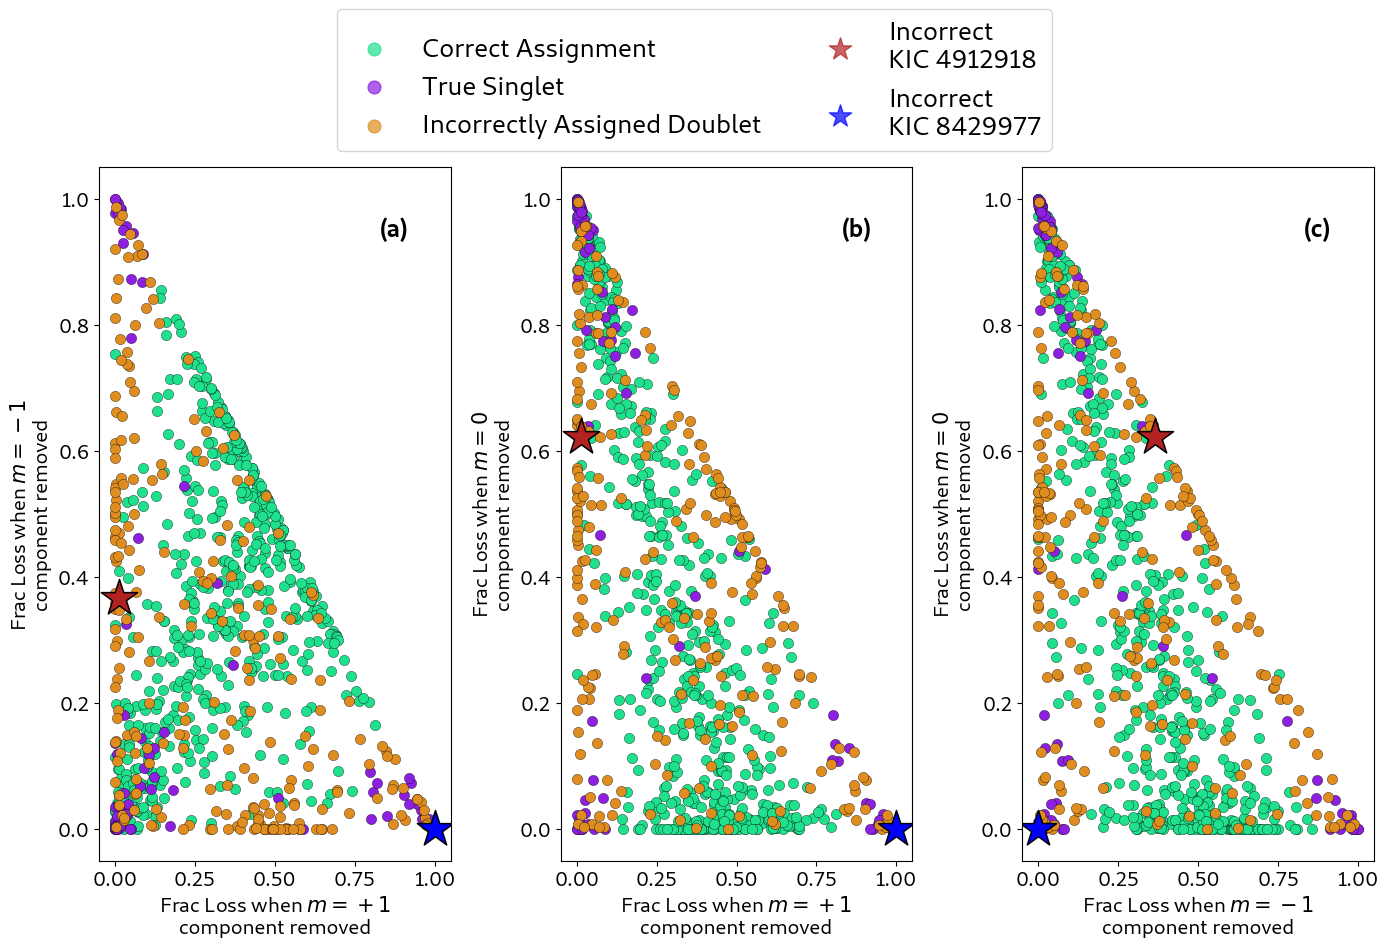

In [179]:
eye_labels = ['Correct Assignment', 'True Singlet', 'Incorrectly Assigned Doublet']

fig = plt.figure(figsize=(14,8))
ax1, ax2, ax3 = fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)
axlist = [ax1, ax2, ax3]

colors = ['#1FE08D', '#8D1FE0', '#E08D1F']
labels = ['Frac Loss when $m=+1$\ncomponent removed',
         'Frac Loss when $m=-1$\ncomponent removed',
         'Frac Loss when $m=0$\ncomponent removed']
abc = ['(a)', '(b)', '(c)']
fracs = [p1_frac, n1_frac, sing_frac]
idxes = [ (0, 1), (0, 2), (1, 2) ]

fs = 15

for i,ax in enumerate(axlist):
    ax.scatter(fracs[idxes[i][0]][donefile.rotation_flag == 0], fracs[idxes[i][1]][donefile.rotation_flag == 0],
               c=colors[0], edgecolor='k', lw=0.25, s=55)
    ax.scatter(fracs[idxes[i][0]][donefile.rotation_flag == 1], fracs[idxes[i][1]][donefile.rotation_flag == 1],
               c=colors[1], edgecolor='k', lw=0.25, s=55)
    ax.scatter(fracs[idxes[i][0]][donefile.rotation_flag == 3], fracs[idxes[i][1]][donefile.rotation_flag == 3],
               c=colors[2], edgecolor='k', lw=0.25, s=55)
    ax.scatter(fracs[idxes[i][0]][ np.in1d(donefile.KIC, example_kics_doublet)],
               fracs[idxes[i][1]][ np.in1d(donefile.KIC, example_kics_doublet)], 
               c='firebrick', edgecolor='k', lw=1.1, s=750, marker='*')
    ax.scatter(fracs[idxes[i][0]][ np.in1d(donefile.KIC, example_kics_singlet)],
               fracs[idxes[i][1]][ np.in1d(donefile.KIC, example_kics_singlet)], 
               c='blue', edgecolor='k', lw=1.1, s=750, marker='*')
    
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.set_xlabel(labels[idxes[i][0]], fontsize=fs)
    ax.set_ylabel(labels[idxes[i][1]], fontsize=fs)
    ax.text(x=0.8, y=0.9, s=abc[i], fontsize=fs+3, fontweight='bold', transform=ax.transAxes)

model_0 = plt.scatter([],[], s=85, c=np.unique(colors)[0], alpha=0.7)
model_1 = plt.scatter([],[], s=85, c=np.unique(colors)[1], alpha=0.7)
model_2 = plt.scatter([],[], s=85, c=np.unique(colors)[2], alpha=0.7)
ex_0 = plt.scatter([],[], s=285, marker='*', c='firebrick', alpha=0.7)
ex_1 = plt.scatter([],[], s=285, marker='*', c='blue', alpha=0.7)
    
# lech = fig.legend([model_0, model_1, model_2, ex_0, ex_1], 
#                [eye_labels[0], eye_labels[1], eye_labels[2], 'KIC 4912918\nKIC 7777395', 'KIC 8429977\nKIC 8173581'],
#                numpoints=1,
#               handler_map={tuple: HandlerTuple(ndivide=None)}, prop={'size': fs+4}, loc='upper left',
#                  bbox_to_anchor=(0.235,1.195), ncol=2)

lech = fig.legend([model_0, model_1, model_2, ex_0, ex_1], 
               [eye_labels[0], eye_labels[1], eye_labels[2], 'Incorrect\nKIC 4912918', 'Incorrect\nKIC 8429977'],
               numpoints=1,
              handler_map={tuple: HandlerTuple(ndivide=None)}, prop={'size': fs+4}, loc='upper left',
                 bbox_to_anchor=(0.235,1.195), ncol=2)



plt.tight_layout()
# plt.savefig('/home/marc/notebooks/sloscillations/sloscillations/paper/figures/fig_appendix_triangle_raw.png', dpi=200)

plt.show()

## Notice that correct assignments are located in very specific regions of the triangle! 

### If we focus on plot (a), the correct fits are located near the origin, the center of the triangle, and the midpoint region of the triangle's hypotenuse. 

### In plot (a), singlets should belong near the origin. There are some at other vertices in the triangle, and these have been incorrectly assigned to other ($m=+1$ or $-1$) rotational components.

### Let us now compare plot (a) of this early version to a vetted version identical to the published version.

In [169]:
vetted = pd.read_csv('/home/marc/notebooks/sloscillations/sloscillations/results_notebooks/mod_donefile_uncertainties_02_08_2022.csv')#.drop(columns=['loss', 'pct_diff1', 'pct_diff2','pct_diff3']) # get rid of old
vetted = vetted.merge(donefile[['KIC']], on='KIC')
vetted

,KIC,DPi1,q,eps_g,drot,incl,e_incl_pos,e_incl_neg,gehan_n_comp,gehan_dnu,...,eps_g_E,drot_e,drot_E,prime_kosts,pct_diff1,pct_diff2,pct_diff3,sing_frac,p1_frac,n1_frac
0,1723752,83.938,0.160,0.206,0.671,36.4,11.3,11.3,3,15.04,...,0.013082,0.016047,0.024765,0.044209,1011.93,59.69,243.21,0.769628,0.045398,0.184974
1,1430118,83.029,0.155,0.330,0.279,68.8,21.2,8.9,2,13.37,...,0.033975,0.044909,0.188027,0.096939,10.79,577.43,847.47,0.007516,0.402197,0.590288
2,2018537,80.694,0.144,0.334,0.226,31.4,13.6,31.4,1,13.89,...,0.015998,0.025989,0.005660,0.015763,343.42,51.61,22.37,0.822760,0.123646,0.053594
3,1726291,82.546,0.176,0.290,0.541,40.7,12.8,12.8,3,12.92,...,0.012653,0.015781,0.015677,0.019588,360.46,150.53,83.77,0.606060,0.253094,0.140847
4,1569842,80.708,0.155,0.195,0.366,32.5,13.8,13.8,3,11.85,...,0.105483,0.027267,0.029640,0.019076,475.08,184.15,142.42,0.592628,0.229714,0.177659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,12155459,88.219,0.164,0.273,0.288,82.1,7.9,2.7,2,16.45,...,0.049921,0.010870,0.020571,0.063182,15.64,333.30,474.91,0.018984,0.404564,0.576452
919,11960195,78.433,0.134,0.244,0.282,57.9,10.5,10.5,3,11.81,...,0.054561,0.024534,0.021573,0.041037,218.08,119.17,440.86,0.280269,0.153153,0.566578
920,11391750,72.336,0.120,-0.027,0.000,28.0,12.0,28.0,1,8.02,...,0.028144,0.000000,0.000000,0.034022,0.00,0.00,0.00,NaN,NaN,NaN
921,12203243,84.725,0.155,0.094,0.000,20.9,8.8,20.9,1,15.28,...,0.062777,0.000000,0.000000,0.070669,0.00,0.00,0.00,NaN,NaN,NaN


## Let's plot OUR results, cross-matched with reported inclination angles and number of components from the Gehan+ (2021) paper: https://ui.adsabs.harvard.edu/abs/2021A%2526A...645A.124G%252F/

In [170]:
## Converting into fractions ##
sing_frac = vetted['pct_diff1']/(vetted['pct_diff1']+vetted['pct_diff2']+vetted['pct_diff3'])
p1_frac = vetted['pct_diff2']/(vetted['pct_diff1']+vetted['pct_diff2']+vetted['pct_diff3'])
n1_frac = vetted['pct_diff3']/(vetted['pct_diff1']+vetted['pct_diff2']+vetted['pct_diff3'])

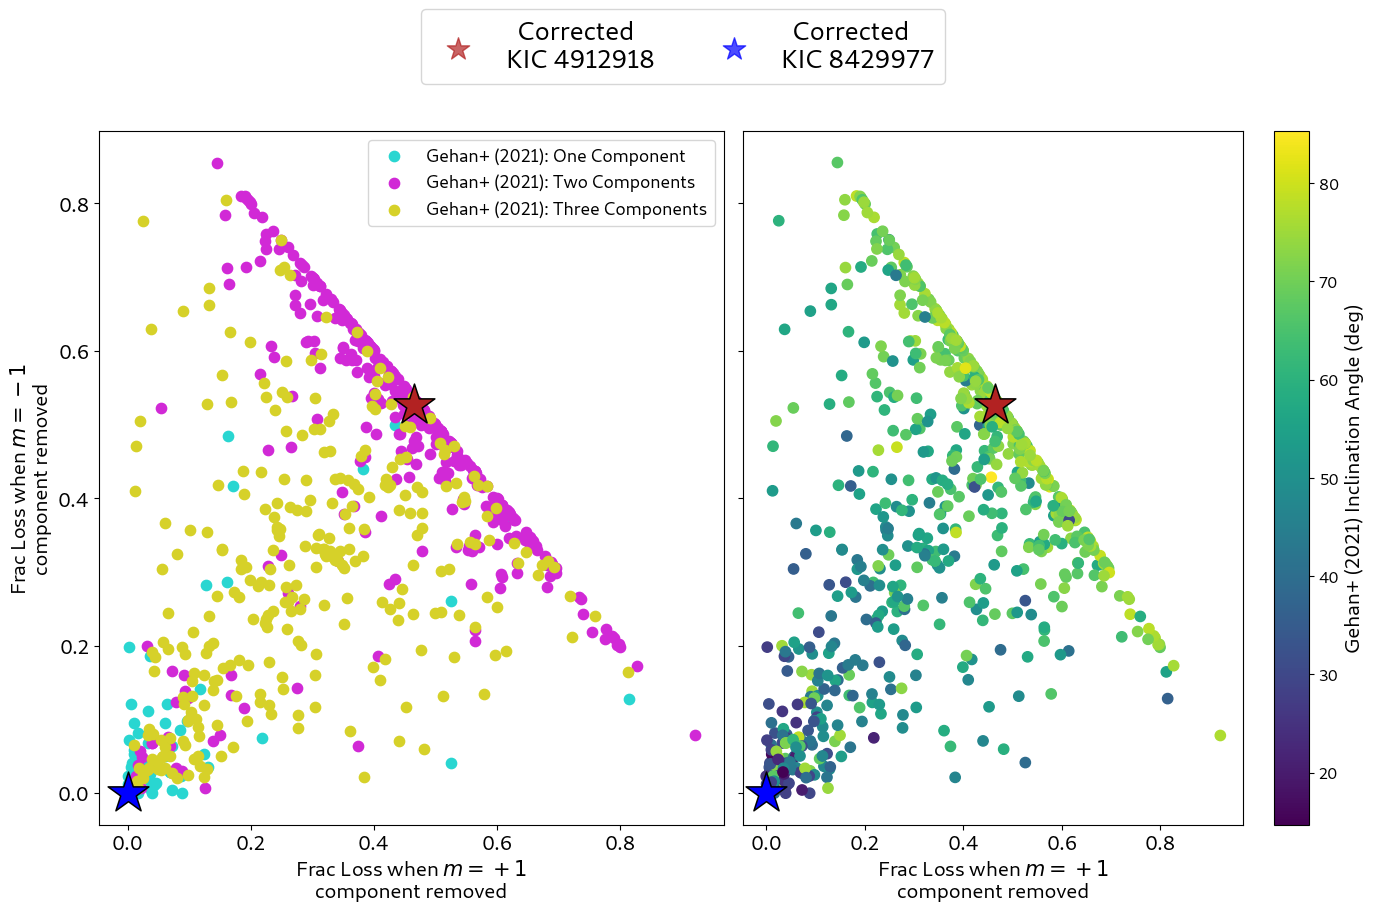

In [172]:
fs = 15

fig = plt.figure(figsize=(14,8))
ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)
axlist = [ax1, ax2]

colors = ['#29D6D1', '#D129D6', '#D6D129']
labels = ['Gehan+ (2021): One Component', 
          'Gehan+ (2021): Two Components', 
          'Gehan+ (2021): Three Components']

abc = ['(a)', '(b)']

for i, nc in enumerate(np.unique(vetted.gehan_n_comp.values)):  
    ax1.scatter(p1_frac[vetted.gehan_n_comp == nc], n1_frac[vetted.gehan_n_comp == nc],
                s=55, color=colors[i], label=labels[i])

ax1.scatter(p1_frac[ np.in1d(vetted.KIC, example_kics_doublet)],
       n1_frac[ np.in1d(vetted.KIC, example_kics_doublet)], 
       c='firebrick', edgecolor='k', lw=1.1, s=950, marker='*')
ax1.scatter([0], [0], 
       c='blue', edgecolor='k', lw=1.1, s=950, marker='*')

ax1.legend(loc='upper right', prop={'size': fs-2})


im2 = ax2.scatter(p1_frac, n1_frac,
                s=55, c=vetted.incl)
cb = fig.colorbar(im2, ax=ax2)

ax2.scatter(p1_frac[ np.in1d(vetted.KIC, example_kics_doublet)],
       n1_frac[ np.in1d(vetted.KIC, example_kics_doublet)], 
       c='firebrick', edgecolor='k', lw=1.1, s=950, marker='*')
ax2.scatter([0], [0], 
       c='blue', edgecolor='k', lw=1.1, s=950, marker='*')

cb.set_label('Gehan+ (2021) Inclination Angle (deg)', fontsize=fs)
cb.ax.tick_params(labelsize=fs-3) 

ax2.set_yticklabels([])
ax1.set_xlabel('Frac Loss when $m=+1$\ncomponent removed', fontsize=fs)
ax1.set_ylabel('Frac Loss when $m=-1$\ncomponent removed', fontsize=fs)
ax2.set_xlabel('Frac Loss when $m=+1$\ncomponent removed', fontsize=fs)

ax1.tick_params(axis='both', which='major', labelsize=fs)
ax2.tick_params(axis='both', which='major', labelsize=fs)

ex_0 = plt.scatter([],[], s=285, marker='*', c='firebrick', alpha=0.7)
ex_1 = plt.scatter([],[], s=285, marker='*', c='blue', alpha=0.7)
    
# lech = fig.legend([ex_0, ex_1], 
#                ['  Corrected\nKIC 4912918\nKIC 7777395', '  Corrected\nKIC 8429977\nKIC 8173581'],
#                numpoints=1,
#               handler_map={tuple: HandlerTuple(ndivide=None)}, prop={'size': fs+4}, loc='upper left',
#                  bbox_to_anchor=(0.295,1.15), ncol=2)

lech = fig.legend([ex_0, ex_1], 
               ['  Corrected\nKIC 4912918', '  Corrected\nKIC 8429977'],
               numpoints=1,
              handler_map={tuple: HandlerTuple(ndivide=None)}, prop={'size': fs+4}, loc='upper left',
                 bbox_to_anchor=(0.295,1.15), ncol=2)

plt.tight_layout()

plt.show()

# Compare the distribution of this vetted version with the early version before!


## The number of components and inclination results from Gehan+ (2021) agrees with our intuition! 

## If the spectrum only has two rotationally split components, then the removal our either $m=+1$ or $-1$ components results in equal contributions to the loss, and we should expect them to roughly fall along the locus describing the hypotenuse of this triangle. 

## Meanwhile, if there is only one component, then it should fall along regions close to the triangle vertex near the origin.

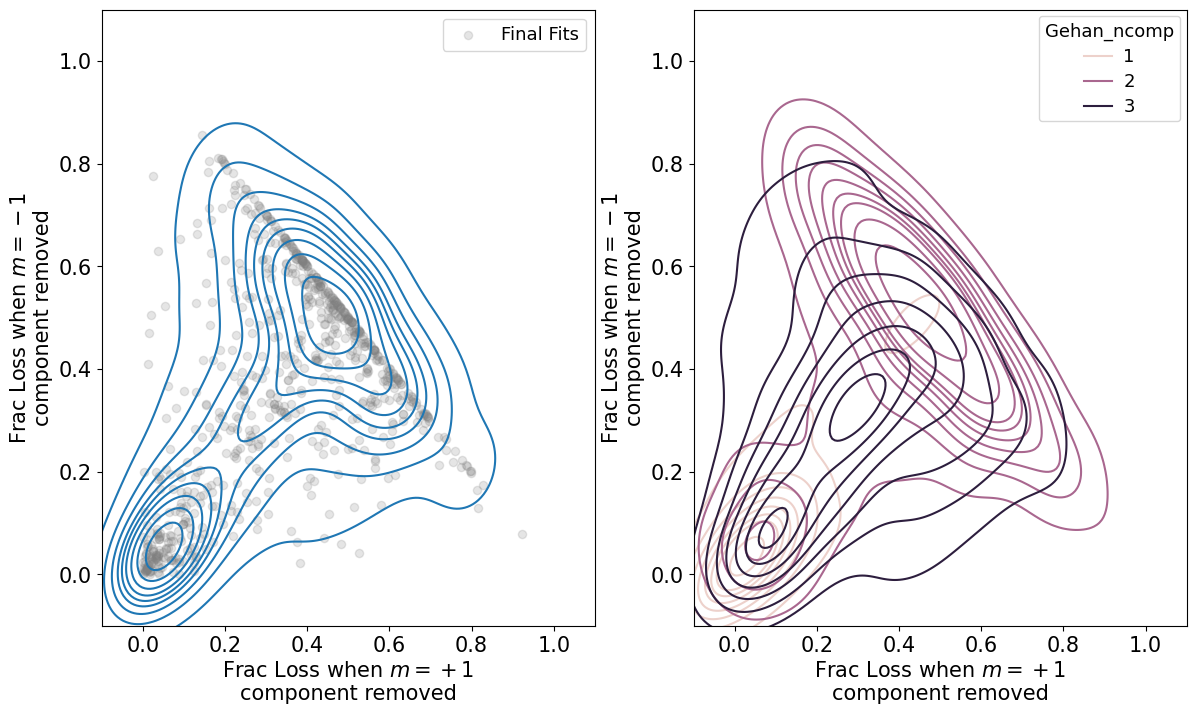

In [143]:
from scipy import stats
import seaborn as sns

kde_data = pd.DataFrame({'Frac Loss when $m=+1$\ncomponent removed': p1_frac[~np.isnan(n1_frac)],
                        'Frac Loss when $m=-1$\ncomponent removed': n1_frac[~np.isnan(n1_frac)],
                        'Gehan_ncomp': vetted[~np.isnan(n1_frac)].gehan_n_comp.values})

fs = 15

fig = plt.figure(figsize=(14,8))
ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)

sns.kdeplot(data=kde_data, x="Frac Loss when $m=+1$\ncomponent removed",
            y="Frac Loss when $m=-1$\ncomponent removed", ax=ax1)
ax1.scatter(p1_frac, n1_frac,
                s=35, color='gray', alpha=0.2, label='Final Fits')
ax1.legend(prop={'size': fs-2})

sns.kdeplot(data=kde_data, x="Frac Loss when $m=+1$\ncomponent removed",
            y="Frac Loss when $m=-1$\ncomponent removed", hue='Gehan_ncomp',  ax=ax2, legend=True)
plt.setp(ax2.get_legend().get_texts(), fontsize=fs-2) # for legend text
plt.setp(ax2.get_legend().get_title(), fontsize=fs-2) # for legend text

ax1.tick_params(axis='both', which='major', labelsize=fs)
ax2.tick_params(axis='both', which='major', labelsize=fs)

for ax in [ax1, ax2]:
    ax.set_xlabel('Frac Loss when $m=+1$\ncomponent removed', fontsize=fs)
    ax.set_ylabel('Frac Loss when $m=-1$\ncomponent removed', fontsize=fs)
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)

plt.show()

# In principle, this means this diagnostic defines a distribution within this 'triangle' plot that can help us inform whether or not a fit is good, as shown in the KDE plots above. Going further, where exactly the points fall in this diagram as shown in the right panel can provide us hints as to the number of potential observed rotational components!